In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import sparse_ir
from numpy.fft import fftn, ifftn

In [2]:
lambda_ = 1e+5
beta = 1e+3
eps = 1e-7
# Number of divisions along each reciprocal lattice vector
# Note: For a smaller nk (e.g., 64), an unphysical small structures appear in the self-energy at low frequencies.
#nk_lin = 256
nk_lin = 256
U = 2.0 # Onsite repulsion

wmax = lambda_/beta
basis = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=eps)
L = basis.size

# Sparse sampling in tau
smpl_tau = sparse_ir.TauSampling(basis)
ntau = smpl_tau.sampling_points.size
print("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = sparse_ir.MatsubaraSampling(basis)
nw = smpl_matsu.sampling_points.size
print("cond (matsu): ", smpl_matsu.cond)

cond (tau): 

178.7075706855871

cond (matsu): 

423.4519199332223

(256, 256)

(256, 256)

(256, 256)

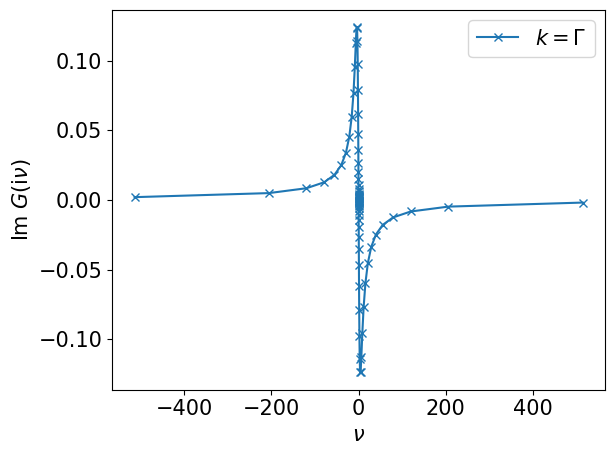

In [3]:
kps = (nk_lin, nk_lin)
nk = np.prod(kps)
nr = nk
kgrid = [2*np.pi*np.arange(kp)/kp for kp in kps]
k1, k2 = np.meshgrid(*kgrid, indexing="ij")
ek = -2*(np.cos(k1) + np.cos(k2))
print(k1.shape, k2.shape, ek.shape)

iv = 1j*np.pi*smpl_matsu.sampling_points/beta
gkf = 1.0 / (iv[:,None] - ek.ravel()[None,:])

plt.plot(smpl_matsu.sampling_points*np.pi/beta, gkf[:,0].imag, label=r"$k=\Gamma$", marker="x")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\mathrm{Im}~G(\mathrm{i}\nu)$")
plt.legend()
plt.tight_layout()
plt.show()

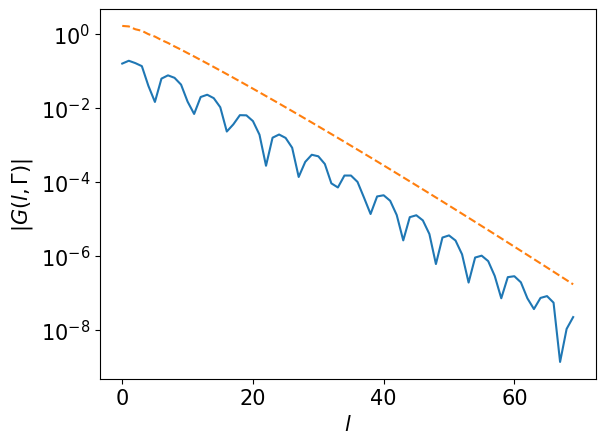

In [4]:
# G(l, k): (L, nk)
gkl = smpl_matsu.fit(gkf, axis=0)

assert gkl.shape == (L, nk)

plt.semilogy(np.abs(gkl[:,0]))
plt.semilogy(basis.s, ls="--")
plt.xlabel(r"$l$")
plt.ylabel(r"$|G(l, \Gamma)|$")
plt.show()

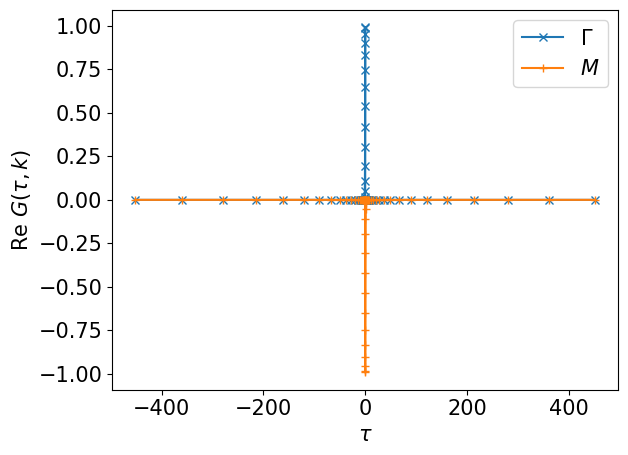

In [5]:
gkt = smpl_tau.evaluate(gkl)

assert gkt.shape == (ntau, nk)

plt.plot(smpl_tau.sampling_points, gkt[:,0].real, label=r'$\Gamma$', marker="x")
plt.plot(smpl_tau.sampling_points, 
    gkt.reshape(-1,*kps)[:,nk_lin//2,nk_lin//2].real, label=r'$M$', marker="+")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathrm{Re}~G(\tau, k)$")
plt.legend()
plt.tight_layout()
plt.show()

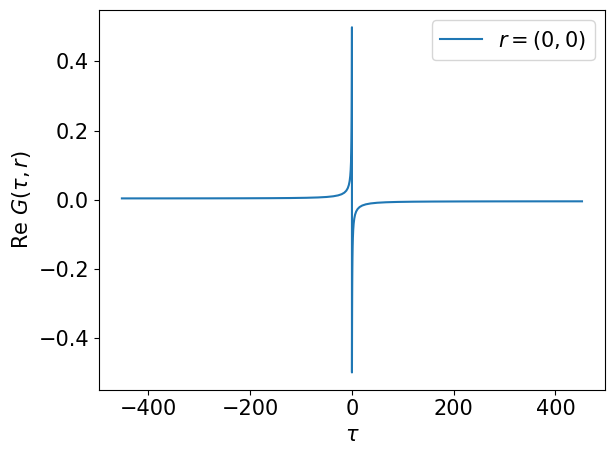

In [6]:
# Compute G(tau, r): (ntau, nk)
#  (1) Reshape gkt into shape of (ntau, nk_lin, nk_lin).
#  (2) Apply FFT to the axes 1, 2.
#  (3) Reshape the result to (ntau, nk)
# G(tau, k): (ntau, nk)
grt = fftn(gkt.reshape(ntau, *kps), axes=(1,2)).reshape(ntau, nk)/nk

plt.plot(smpl_tau.sampling_points, grt[:,0].real, label='$r=(0,0)$')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathrm{Re}~G(\tau, r)$")
plt.legend()
plt.tight_layout()
plt.show()

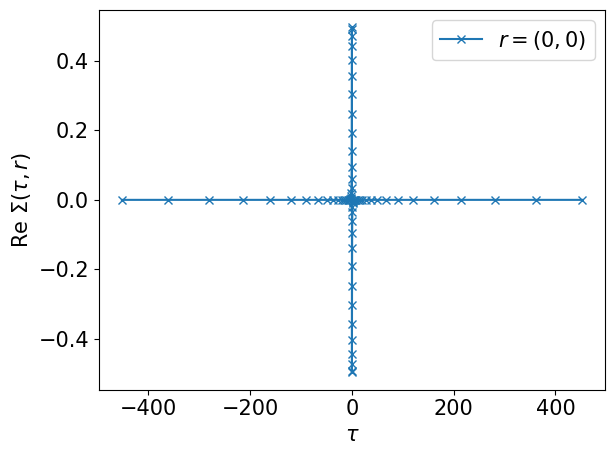

In [7]:
# Sigma(tau, r): (ntau, nr)
srt = - U*U*grt*grt*grt[::-1,:]

plt.plot(smpl_tau.sampling_points, srt[:,0].real, label='$r=(0,0)$', marker="x")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathrm{Re}~\Sigma(\tau, r)$")
plt.legend()
plt.tight_layout()
plt.show()

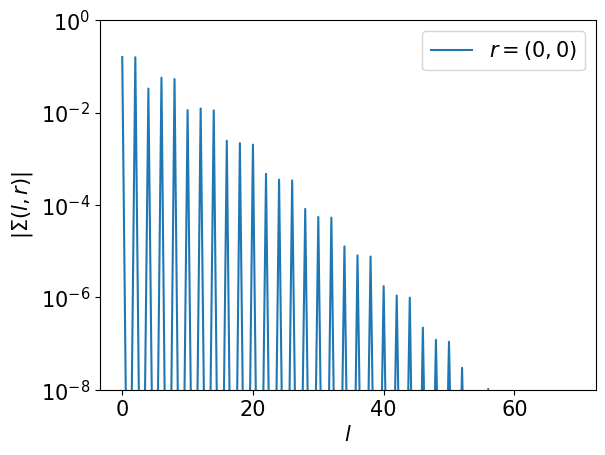

In [8]:
# Sigma(l, r): (L, nr)
srl = smpl_tau.fit(srt)
assert srl.shape == (L, nr)

plt.semilogy(np.abs(srl[:,0]), label='$r=(0,0)$')
plt.xlabel(r"$l$")
plt.ylabel(r"$|\Sigma(l, r)|$")
plt.ylim([1e-8,1])
plt.legend()
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\G'
<>:7: SyntaxWarning: invalid escape sequence '\G'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_58190/1387464666.py:7: SyntaxWarning: invalid escape sequence '\G'
  plt.semilogy(np.abs(skl[:,0,0]), label="$k=\Gamma$")


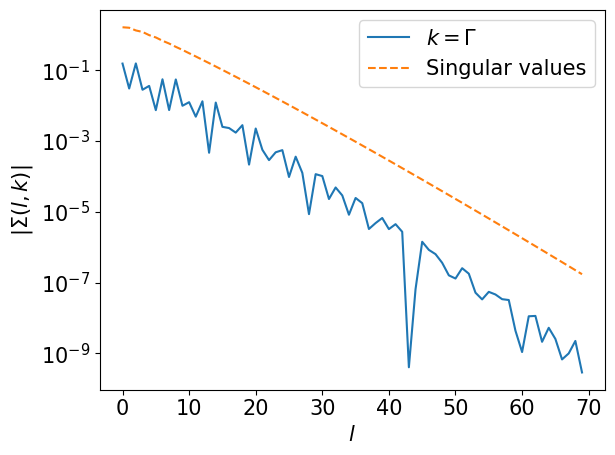

In [9]:
# Sigma(l, k): (L, nk)
srl = srl.reshape(L, *kps)
skl = ifftn(srl, axes=(1,2)) * nk
skl = skl.reshape(L, *kps)

#plt.semilogy(np.max(np.abs(skl),axis=(1,2)), label="max, abs")
plt.semilogy(np.abs(skl[:,0,0]), label="$k=\Gamma$")
plt.semilogy(basis.s, label="Singular values", ls="--")
plt.xlabel(r"$l$")
plt.ylabel(r"$|\Sigma(l, k)|$")
plt.legend()
plt.tight_layout()
plt.show()

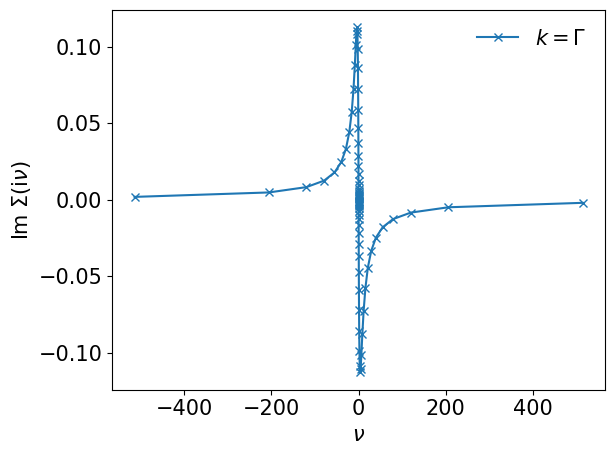

In [10]:
sigma_iv = smpl_matsu.evaluate(skl, axis=0)
plt.plot(smpl_matsu.sampling_points*np.pi/beta, sigma_iv[:,0,0].imag, marker='x', label=r"$k=\Gamma$")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\mathrm{Im}~\Sigma(\mathrm{i}\nu)$")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

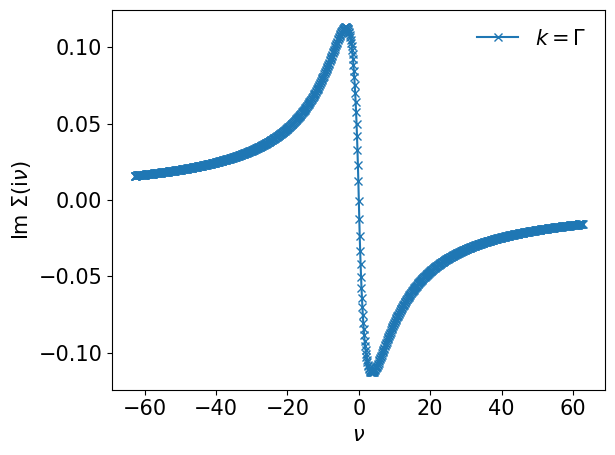

In [11]:
my_freqs = 2*np.arange(-10000, 10000, 20) + 1 # odd
smpl_matsu2 = sparse_ir.MatsubaraSampling(basis, my_freqs)
res = smpl_matsu2.evaluate(skl, axis=0)
plt.plot(my_freqs*np.pi/beta, res[:,0,0].imag, marker='x', label=r"$k=\Gamma$")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\mathrm{Im}~\Sigma(\mathrm{i}\nu)$")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()